# Simple Sokoban

The game of Sokoban is a a classical japanese game...

# The environment
The environment is a NxN array of integers. Each cell of this environment can have the following values:

- 0 : empty cell
- 1 : obstacle, non-traversable
- 2 : Box
- 3 : Storage location

All border cells are obstacles. Upon initialization, the environment has:

- 1 Box placed randomly in the environment
- 1 storage location placed in a random corner of the environment

# The game
The agent starts in a random empty cell, and has to move the boxes into the storage locations. For now, the boxes and storage locations are indistinguishable, meaning any box can be placed in any storage location

At each timestep:

- the agent decides on an action (move up, left, right or down)
- the action is sent to the environment
- the environment sends back observations, rewards and a boolean that indicates whether the environment terminated.
- The environment terminates if the agent reaches the exit, 

??or if the environement reaches a time limit of N^2 timesteps.??

# States

Since both the agent and box can be in any of the (free) cells in the grid,
the state space is O(N**4)

# Rewards

The agent recieves a reward each timestep, depending on where the action takes it:
- If the agent bumps into a wall, it will recieve a reward of -5
- If the agent pushes the box into a valid location, it will recieve a reward of 0
- If the agent pushes the box into a wall, it will recieve a reward of -10, and both the agent and the box will remain at their original locations
- If the agent correctly places the box, it will recieve a reward of N* N
- Additionally, the agent will recieve a reward of -1 each timestep

In [63]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from collections import namedtuple




In [64]:
# First define a namedtuple to hold useful information for actions
Action = namedtuple('Action', 'name index delta_i delta_j' )
up = Action('up', 0, -1, 0)    
down = Action('down', 1, 1, 0)    
left = Action('left', 2, 0, -1)    
right = Action('right', 3, 0, 1) 

# Use a dictionary to convert indices to actions using the index as a key
# Useful for sampling actions for a given state
index_to_actions = {}
for action in [up, down, left, right]:
    index_to_actions[action.index] = action 
    
# Helpful function to convert action in string format to the action object
str_to_actions = {}
for action in [up,down,left,right]:
    str_to_actions[action.name] = action




class Sokoban():
    def __init__(self, N):
        self.sokoban = np.zeros((N,N))
        self.size = N
        
        #Reward/transition/Value matrices
        self.reward_matrix = -1*np.ones( (N**4,4))
        self.transition_matrix = np.zeros((N**4,4,N**4))
        
        
        self.sokoban[0, :] = 1 #top row
        self.sokoban[:, 0] = 1 # left column
        self.sokoban[-1, :] = 1 # bottom row
        self.sokoban[:, -1] = 1 #right column
        
        # List of possible exits
        self.exits = [[1,1],[1,-2],[-2,1],[-2,-2] ]
        
        for corner in self.exits:
            self.sokoban[corner[0],corner[1]] = 3
        

       
        
        
        
        # Agent's and box's position will be determined upon reset
        self.position_agent = None
        self.position_box = None
                                        

        # run time
        self.time_elapsed = 0
        #self.time_limit = self.size**2
        
                # display help
        self.dict_map_display={ 0:'.',
                                1:'X',
                                2:'B',
                                3:'E',
                                #4:'!',
                                5:'A'} #for displaying type of cell
        
        
        # Assign random index for each coordinate in the grid
        index_sub_states = np.arange(0,N*N)
        np.random.shuffle(index_sub_states)
        self.coord_to_index = index_sub_states.reshape(N,N)
        
        # Then combine pairs of indices to get a single state for the environment 
        index_complete_states = np.arange(0,N**4)
        np.random.shuffle(index_complete_states)
        self.index_pairs_to_state = index_complete_states.reshape(N*N,N*N)
        
        #Fill the matrices
        # ** TO-DO: clean up?
        for k in range(1,N-1):
            for l in range(1,N-1):
                for i in range(1,N-1):
                    for j in range(1,N-1):
                        
                        # First calculate current indices, state, cell type
                        current_agent_index = self.coord_to_index[i,j]
                        current_box_index = self.coord_to_index[k,l]
                        current_state = self.index_pairs_to_state[current_box_index,current_agent_index]
                        current_cell = self.sokoban[i,j]

                    
                        for action in [up,left,down,right]:
                            # Lookahead one step for agent
                            dest_coords = [i+action.delta_i,j+action.delta_j]
                            destination_cell = self.sokoban[i+action.delta_i,j+action.delta_j]
                            next_agent_index = self.coord_to_index[i+action.delta_i,j+action.delta_j]                            
                            
                            # Write NAN when box and agent overlap...
                            if current_agent_index == current_box_index:
                                self.reward_matrix[current_state, action.index] = np.NAN
                            
                            # Check for direct bump with wall
                            if destination_cell == 1:
                                self.transition_matrix[current_state, action.index, current_state] = 1 
                                #destination_cell = current_cell 
                                #next_state = current_state
                                self.reward_matrix[current_state, action.index] += -5   
                                #self.reward_matrix[current_box_index,current_agent_index, action.index] = -5   
                        
                            # Case when agent moves to other valid cell
                            if destination_cell in [0,3]:
                                next_state = self.index_pairs_to_state[current_box_index,next_agent_index]
                                self.transition_matrix[current_state,action.index,next_state] = 1
                            
                            # Case when agent pushes box
                            if next_agent_index == current_box_index:
                                # Case when agent pushes box into wall
                                if self.sokoban[i+(2*action.delta_i),j+(2*action.delta_j)] ==1:
                                    self.transition_matrix[current_state, action.index, current_state] = 1
                                    #destination_cell = current_cell
                                    self.reward_matrix[current_state,action.index]+=-10
                                
                                # Else look at cases when push is valid
                                else:
                                    # Now calculate one-step lookahead for box
                                    destination_box_cell = self.sokoban[i+2*action.delta_i,j+action.delta_j]
                                    next_box_index = self.coord_to_index[i+(2*action.delta_i),j+(2*action.delta_j)]
                                    next_state = self.index_pairs_to_state[next_box_index,next_agent_index]
                                    self.transition_matrix[current_state,action.index,next_state] = 1
                                    # Case when box is pushed to correct location
                                    if destination_box_cell == 3:
                                        self.reward_matrix[current_state,action.index]+=N**2
                                        #self.reward_matrix[current_box_index,current_agent_index,action.index] = N**2
                                    # Case when box is pushed to incorrect corner
                                    #if destination_box_cell == 4:
                                        #self.reward_matrix[current_state,action.index] += -N**2
                                        
                            
                                
                            
        
    # Function to return coordinates after a given action
    def next_pos(self,str_act, old_pos):
        action = str_to_actions[str_act]
        next_position = [old_pos[0]+action.delta_i,old_pos[1]+action.delta_j]
        return np.array(next_position)
        
        
        
    def step(self, action):
        
        reward = -1
        bump = False
        done = False
        
        # Store new agent position
        next_agent_position = self.next_pos(action, self.position_agent)

        # First check if agent bumps into wall
        if self.sokoban[next_agent_position[0],next_agent_position[1]] ==1:
            bump = True
            
        
        # Now see if agent pushes box
        
        if (next_agent_position == self.position_box).all():

            
            # Find new box position
            next_box_position = self.next_pos(action, self.position_box)

            
            # Check if box get pushed into wall
            if self.sokoban[next_box_position[0], next_box_position[1]] == 1:
                reward-=10
            
            # Otherwise move agent and box
            if self.sokoban[next_box_position[0], next_box_position[1]] in [0,3,4]:
                self.position_box = next_box_position
                self.position_agent = next_agent_position
                
                
        # Case where agent moves into any other valid cell 
        elif self.sokoban[next_agent_position[0],next_agent_position[1]] !=1:
            self.position_agent = next_agent_position
                
        # Calculate rewards
        cell_type = self.sokoban[self.position_box[0],self.position_box[1]]
        if cell_type == 3:
            reward+=self.size**2
            done = True
            print("Epsisode complete!")
            
        #if cell_type==4:
            #reward-=self.size**2
            #print("Episode Failed! (Reached dead state)")
            #done = True

        if bump:
            reward -=5
            
        # get observations
        obs = self.calculate_observations()
                                                           
        state = self.index_pairs_to_state[self.coord_to_index[self.position_agent[0],self.position_agent[1]],
                                    self.coord_to_index[self.position_box[0],self.position_box[1]] ]                                   
        
        # Update time
        self.time_elapsed +=1

        
        return state, obs, reward, done
    
    def display(self):
        
        envir_with_agent = self.sokoban.copy() 
        envir_with_agent[self.position_agent[0], self.position_agent[1]] = 5 #add agent into grid
        envir_with_agent[self.position_box[0], self.position_box[1]] = 2 #add box into grid 
        full_repr = ""

        for r in range(self.size):
            
            line = ""
            
            for c in range(self.size):

                string_repr = self.dict_map_display[ envir_with_agent[r,c] ] #display
                
                line += "{0:2}".format(string_repr)

            full_repr += line + "\n"

        print(full_repr)

        
    # A function to print a  'snapshot' of possible rewards from current timestep
    def print_reward_matrices(self):
        
        for action in [up,down,left,right]:
            
            # Get index of box coordinates
            box_index = self.coord_to_index[self.position_box[0],self.position_box[1]]

            
            # New matrix to display rewards            
            reward_matrix =  np.zeros( (self.size,self.size) )
            
            for i in range(1, self.size-1):
                    for j in range(1, self.size-1):

                        agent_index = self.coord_to_index[i,j]
                        state = self.index_pairs_to_state[box_index,agent_index]
                        reward_matrix[i,j] = self.reward_matrix[state, action.index]
                        
            print( action.name)
            print(reward_matrix) #for the given action, what reward would I get if I took that action from a particular state?
    
                                                           

            
            
        
    def calculate_observations(self):
        
        agent_coordinates = self.position_agent
        box_coordinates = self.position_box        
        
        obs = {'Agent':agent_coordinates, 'box':box_coordinates}
        return obs
        

    def get_empty_cells(self, n_cells): 
        empty_cells_coord = np.where( self.sokoban == 0 ) #find empty cells
        selected_indices = np.random.choice( np.arange(len(empty_cells_coord[0])), n_cells ) 
        selected_coordinates = empty_cells_coord[0][selected_indices], empty_cells_coord[1][selected_indices] #turn into coordinates
        
        if n_cells == 1:
            return np.asarray(selected_coordinates).reshape(2,) 
        
        return selected_coordinates
        
    def reset(self):
        """
        This function resets the environment to its original state (time = 0).
        Then it places the agent and exit at new random locations.
        
        """
        self.time_elapsed = 0
        
        # position of the agent is a numpy array
        empty_cells = np.asarray(self.get_empty_cells(2))
        self.position_agent = empty_cells[0]
        self.position_box = empty_cells[1]
        
        # In the case where box and agent reset to same location, repeat until they no longer do
        if (self.position_agent == self.position_box).all():
                self.reset()

        # Calculate observations
        observations = self.calculate_observations()
        
        
        state = self.index_pairs_to_state[ self.coord_to_index[self.position_agent[0], self.position_agent[1]],
                                          self.coord_to_index[self.position_box[0],self.position_box[1]] ]
        
        return state

In [65]:
sokoban = Sokoban(8)
sokoban.reset()
sokoban.display()
print(sokoban.exits)

X X X X X X X X 
X E . . . . E X 
X . . . . . A X 
X . . . . . . X 
X . . . . . . X 
X . . . . . . X 
X E . . B . E X 
X X X X X X X X 

[[1, 1], [1, -2], [-2, 1], [-2, -2]]


In [66]:
state, obs, rew, done = sokoban.step('up')
print(obs,rew,done)
sokoban.display()
sokoban.print_reward_matrices()

{'Agent': array([1, 6], dtype=int64), 'box': array([6, 4], dtype=int64)} -1 False
X X X X X X X X 
X E . . . . A X 
X . . . . . . X 
X . . . . . . X 
X . . . . . . X 
X . . . . . . X 
X E . . B . E X 
X X X X X X X X 

up
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -6. -6. -6. -6. -6. -6.  0.]
 [ 0. -1. -1. -1. -1. -1. -1.  0.]
 [ 0. -1. -1. -1. -1. -1. -1.  0.]
 [ 0. -1. -1. -1. -1. -1. -1.  0.]
 [ 0. -1. -1. -1. -1. -1. -1.  0.]
 [ 0. -1. -1. -1. nan -1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]
down
[[  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.  -1.  -1.  -1.  -1.  -1.  -1.   0.]
 [  0.  -1.  -1.  -1.  -1.  -1.  -1.   0.]
 [  0.  -1.  -1.  -1.  -1.  -1.  -1.   0.]
 [  0.  -1.  -1.  -1.  -1.  -1.  -1.   0.]
 [  0.  -1.  -1.  -1. -11.  -1.  -1.   0.]
 [  0.  -6.  -6.  -6.  nan  -6.  -6.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]]
left
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -6. -1. -1. -1. -1. -1.  0.]
 [ 0. -6. -1. -1. -1. -1. -1.  0.]
 [ 0. -6. -1. -1. -1. -1. -1.  0.]
 [

In [67]:
# Function that outputs a random action given a state 
def random_policy(state):
    return random.choice(['up', 'down', 'left', 'right'])

# Function to run a single episode for a given environment and a given policy
def run_single_exp(env,policy):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = policy(state)
        state, obs, reward, done = env.step(action)
        total_reward+=reward
        
    return total_reward

def run_experiments(envir, policy, number_exp):
    
    all_rewards = []
    
    for i in range(number_exp):
        
        final_reward = run_single_exp(envir, policy)
        all_rewards.append(final_reward)
    
    max_reward = max(all_rewards)
    mean_reward = np.mean(all_rewards)
    var_reward = np.std(all_rewards)
    
    return all_rewards, max_reward, mean_reward, var_reward

In [68]:
print(run_experiments(sokoban,random_policy,10))

Epsisode complete!
Epsisode complete!
Epsisode complete!
Epsisode complete!
Epsisode complete!
Epsisode complete!
Epsisode complete!
Epsisode complete!
Epsisode complete!
Epsisode complete!
([-204, -105, -68, -2777, -462, -74, -258, -880, -276, -270], -68, -537.4, 780.382367817213)


In [75]:
class Policy():
    
    def __init__(self,environment,gamma):
        self.env = environment
        self.size_env= environment.size
        self.reward_matrix = environment.reward_matrix
        self.transition_matrix = environment.transition_matrix
        self.coord_to_index = environment.coord_to_index
        self.index_pairs_to_state = environment.index_pairs_to_state
        self.size_state_space = environment.size**4
        
        #** NEED TO FIX
        self.position_box = environment.position_box
        print(self.position_box)
        
        # Initialize policy to be a random one
        self.probability_actions = np.ones((self.size_state_space, 4))*0.25 
        
        # We initialize the values to 0
        self.values = np.zeros( self.size_state_space )
        
        
        # Discount factor
        self.gamma = gamma
     
    # Function which samples an action, given a state
    def __call__(self,state):
        
        # Find the probabilities of actions for the given state
        prob_actions = self.probability_actions[state]
        ans = ("WIP")
        # **FINISH
        return ans
    
    # Function that uses a given policy to evaluate the value functions for each state
    def iterative_policy_evaluation(self,n_sweeps):
        
        # Reset the values
        self.values = np.zeros(self.size_state_space)
        
        # Then use bellman expectation equation to iteratively update values
        for n in range(n_sweeps):
            
            self.values = np.sum(self.probability_actions * (self.reward_matrix + 
                                 self.gamma* np.dot(self.transition_matrix,self.values)), axis=1 )
            
            
    def display_values(self):
        
        value_matrix = np.zeros( (self.size_env,self.size_env) )
        
        # Get index of box coordinates
        test = [self.position_box[0],self.position_box[1]]
        print(test)
        box_index = self.coord_to_index[self.position_box[0],self.position_box[1]]
            
        for i in range(1, self.size_env-1):
                for j in range(1, self.size_env-1):

                    agent_index = self.coord_to_index[i,j]
                    state = self.index_pairs_to_state[box_index,agent_index]
                    value_matrix[i,j] = self.values[state]
                        
        return value_matrix
    
    def greedy_improvement(self):
        
        # Get indices of 'best' actions
        argmax_actions = np.argmax(self.reward_matrix + self.gamma * np.dot(self.transition_matrix,self.values), axis=1 )
        
        #Then update policy for each state
        for state in range(self.size_state_space):
            
            greedy_index = argmax_actions[state]
            
            #But only update if this transition is possible!
            if self.transition_matrix[state][greedy_index].sum()!=0:
                
                self.probability_actions[state,:] = 0
                self.probability_actions[state,greedy_index] = 1
                
            
    
    #A function that iteratively evaluates and improves a policy 
    def policy_iteration(self, n_evaluations):
        
        self.iterative_policy_evaluation(n_evaluations)
        self.greedy_improvement()

[2 3]
X X X X X 
X E . E X 
X . A B X 
X E . E X 
X X X X X 

[2, 3]


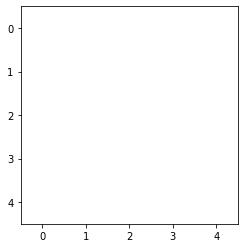

In [76]:
sokoban = Sokoban(5)
sokoban.reset()
policy = Policy(sokoban,gamma=0.4)

for i in range(15):
    values = policy.iterative_policy_evaluation( 10)
    policy.greedy_improvement()

sokoban.display()
vals = policy.display_values()

plt.imshow( (vals - vals.min())/(vals.max() - vals.min()) )
plt.show()